In [14]:
from LogME import LogME
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.manifold import TSNE

In [10]:
def svc_classify(x, y):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    accuracies = []
    f1_scores = []
    for train_index, test_index in kf.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)
        classifier = SVC(C=100000)
        classifier.fit(x_train, y_train)
        classifier_results = classifier.predict(x_test)
        accuracies.append(accuracy_score(y_test, classifier_results))
        #f1_scores.append(f1_score(y_test, classifier_results))
    #return {"accuracy": np.mean(accuracies), "f1": np.mean(f1_scores)}
    return {"accuracy": np.mean(accuracies)}

In [11]:
pretrained_models = ['GCC', 'gin_infomax', 'gin_supervised', 'gin_supervised_contextpred', 'gin_supervised_edgepred', 'gin_supervised_infomax', 'gin_supervised_masking']
datasets = ['imdbb', 'imdbm', 'bbbp', 'bace']
scores = []
accuracies = []
for pretrained_model in pretrained_models:
    curr_scores = {'pretrained_model': pretrained_model}
    curr_accuracies = {'pretrained_model': pretrained_model}
    for dataset in datasets:
        result_path = dataset + "_" + pretrained_model + ".csv"
        result_df = pd.read_csv(result_path, sep = "\t")
        x = np.array(result_df.iloc[:,:-1])
        y = np.array(result_df.iloc[:,-1])
        logme = LogME(regression=False)
        score = logme.fit(x, y)
        curr_scores[dataset] = score
        accuracy = svc_classify(x,y)['accuracy']
        curr_accuracies[dataset] = accuracy
    scores.append(curr_scores)
    accuracies.append(curr_accuracies)
scores = pd.DataFrame(scores)
accuracies = pd.DataFrame(accuracies)

In [13]:
accuracies.to_csv("svc_accuracies.csv", sep = "\t", index = False)
scores.to_csv("logme_scores.csv", sep = "\t", index = False)

In [46]:
result_dfs = {}
pretrained_models = ['GCC', 'gin_infomax', 'gin_supervised', 'gin_supervised_contextpred', 'gin_supervised_edgepred', 'gin_supervised_infomax', 'gin_supervised_masking']
datasets = ['imdbb', 'imdbm', 'bbbp', 'bace']
for pretrained_model in pretrained_models:
    for dataset in datasets:
        result_path = dataset + "_" + pretrained_model + ".csv"
        result_df = pd.read_csv(result_path, sep = "\t")
        tsne_comps = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np.array(result_df.iloc[:,:-1]))
        result_df['tsne1'] = tsne_comps[:,0]
        result_df['tsne2'] = tsne_comps[:,1]
        result_dfs[pretrained_model,dataset] = result_df

In [59]:
params = {'legend.fontsize': 15,
         'axes.labelsize': 10,
         'axes.titlesize':20,
         'xtick.labelsize': 10,
         'ytick.labelsize': 10}
plt.rcParams.update(params)

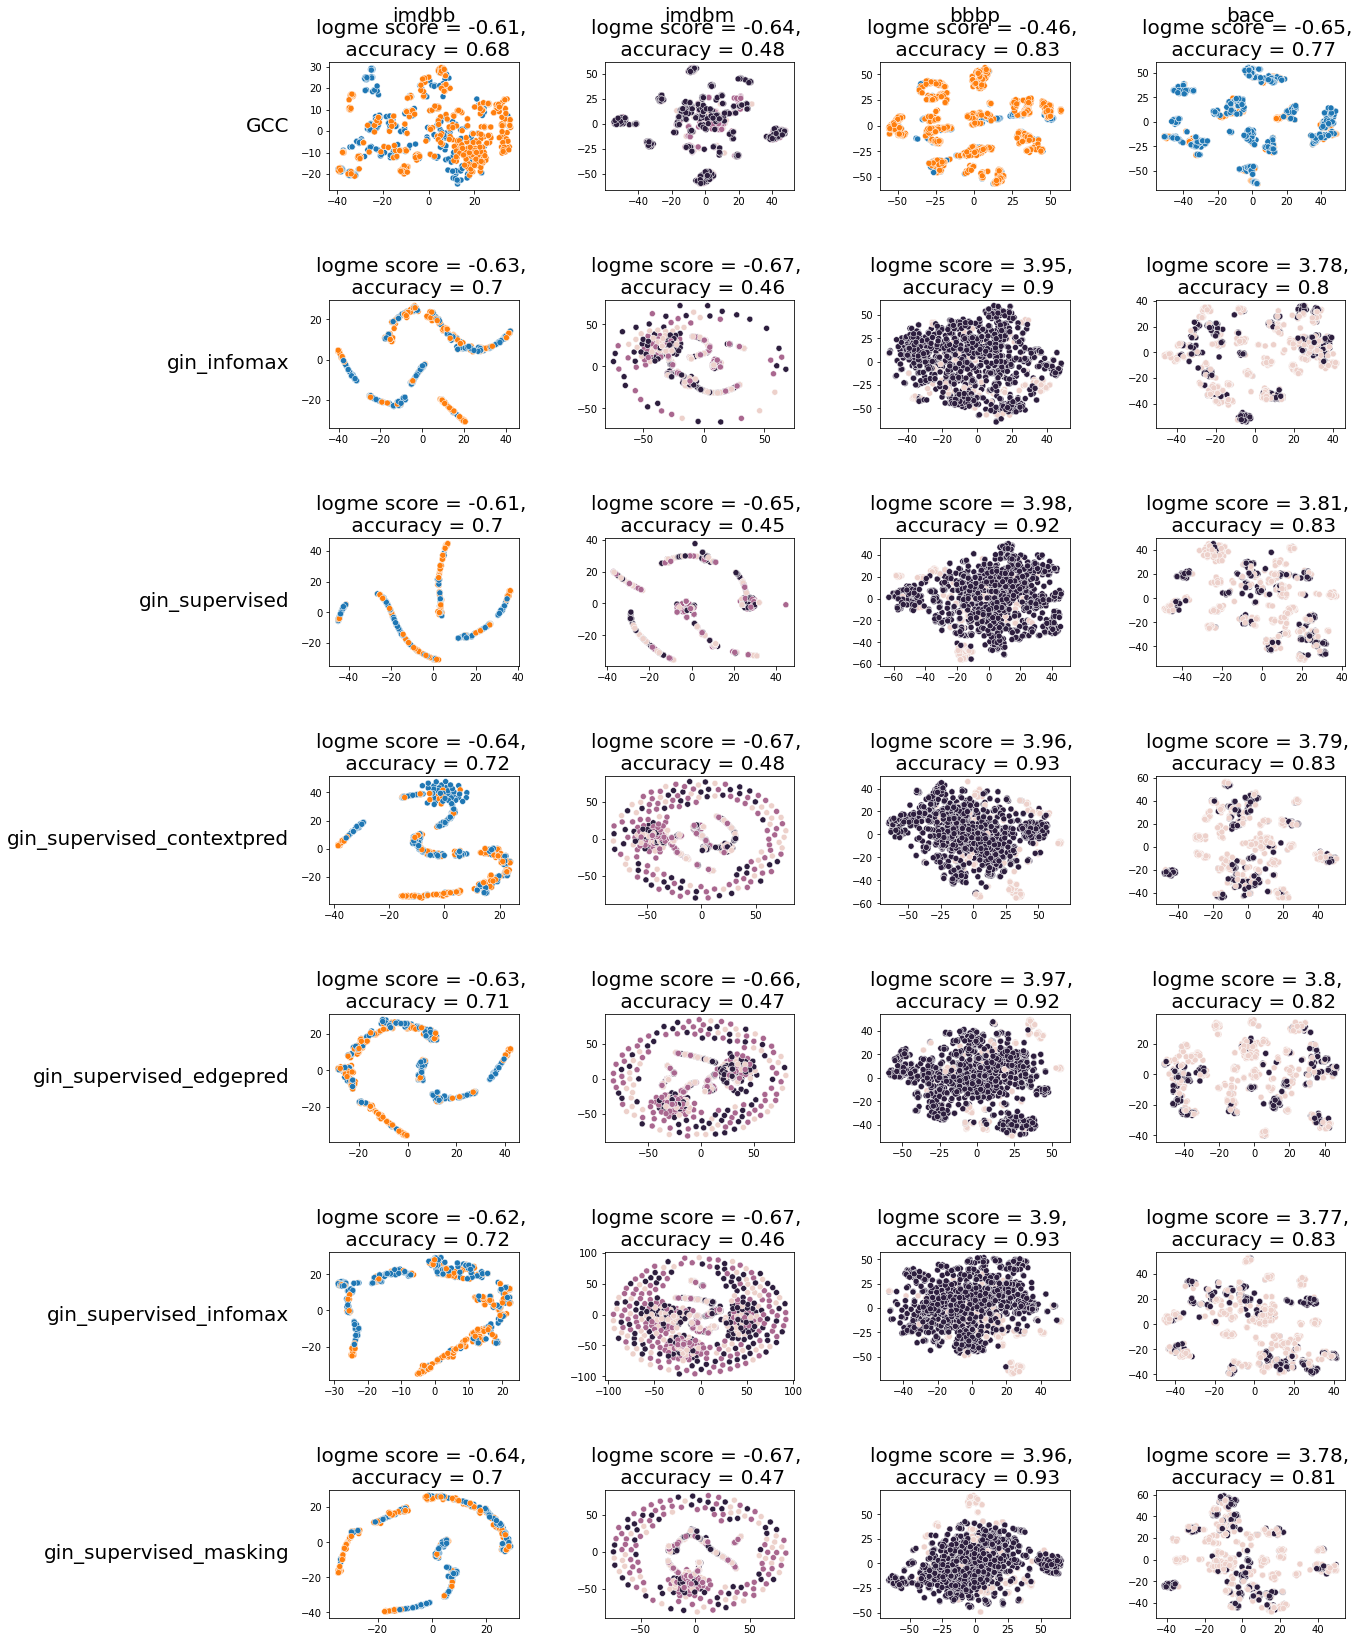

In [86]:
fig, axs = plt.subplots(7,4, figsize = (20,24))
for i,pm in enumerate(pretrained_models):
    for j,dn in enumerate(datasets):
        acc = round(accuracies[accuracies['pretrained_model']==pm][dn].item(),2)
        lm_score = round(scores[scores['pretrained_model']==pm][dn].item(),2)
        sns.scatterplot(data = result_dfs[pm,dn], x = 'tsne1', y = 'tsne2', hue = 'label', ax = axs[i,j])
        axs[i,j].legend_.remove()
        axs[i,j].set_title("logme score = {}, \n accuracy = {}".format(lm_score,acc))
        axs[i,j].set(xlabel = None, ylabel = None)
        
pad = 4 # in points

for ax, col in zip(axs[0], datasets):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 10*pad),
                xycoords='axes fraction', textcoords='offset pixels',
                size=20, ha='center', va='baseline')

for ax, row in zip(axs[:,0], pretrained_models):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset pixels',
                size=20, ha='right', va='center')

fig.tight_layout(pad=1.0)
plt.show()